In [3]:
import os
import torch

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    '''
    TSNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique 
    primarily used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D
    '''
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()



In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

(
    dataset,
    len(dataset),
    dataset.num_features,
    dataset.num_classes,
)

Processing...
/home/macul/deep_simulation/.venv/lib/python3.11/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/home/macul/deep_simulation/.venv/lib/python3.11/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/home/macul/deep_simulation/.venv/lib/python3.11/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/home/ma

(Cora(), 1, 1433, 7)

In [5]:
data = dataset[0]
(
    data,
    data.num_nodes,
    data.num_edges,
    data.train_mask.sum(),
    data.val_mask.sum(),
    data.test_mask.sum(),
    data.has_isolated_nodes(),
    data.has_self_loops(),
    data.is_undirected(),
)

(Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]),
 2708,
 10556,
 tensor(140),
 tensor(500),
 tensor(1000),
 False,
 False,
 True)

In [6]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x
    
model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [7]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 010, Loss: 1.8849
Epoch: 020, Loss: 1.7383
Epoch: 030, Loss: 1.5396
Epoch: 040, Loss: 1.3391
Epoch: 050, Loss: 1.1060
Epoch: 060, Loss: 0.9173
Epoch: 070, Loss: 0.7889
Epoch: 080, Loss: 0.6899
Epoch: 090, Loss: 0.6685
Epoch: 100, Loss: 0.6106
Epoch: 110, Loss: 0.5888
Epoch: 120, Loss: 0.5277
Epoch: 130, Loss: 0.5053
Epoch: 140, Loss: 0.5623
Epoch: 150, Loss: 0.4934
Epoch: 160, Loss: 0.4170
Epoch: 170, Loss: 0.4678
Epoch: 180, Loss: 0.4808
Epoch: 190, Loss: 0.4602
Epoch: 200, Loss: 0.4827


In [8]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


In [9]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


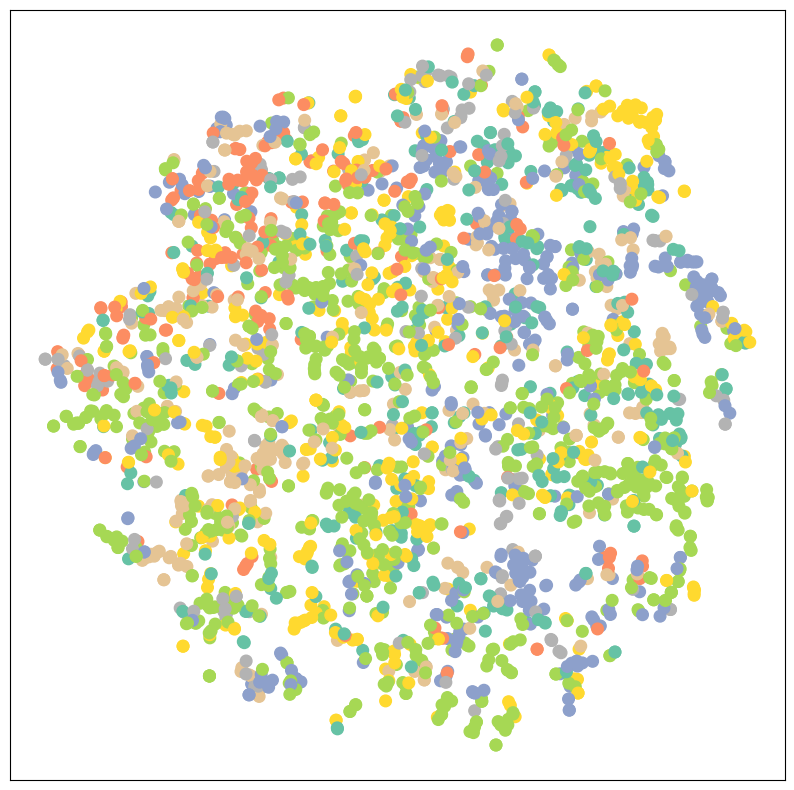

In [10]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [11]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 010, Loss: 1.8769
Epoch: 020, Loss: 1.7760
Epoch: 030, Loss: 1.6204
Epoch: 040, Loss: 1.4216
Epoch: 050, Loss: 1.2363
Epoch: 060, Loss: 1.0039
Epoch: 070, Loss: 0.9249
Epoch: 080, Loss: 0.7583
Epoch: 090, Loss: 0.6778
Epoch: 100, Loss: 0.5881


In [12]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8020


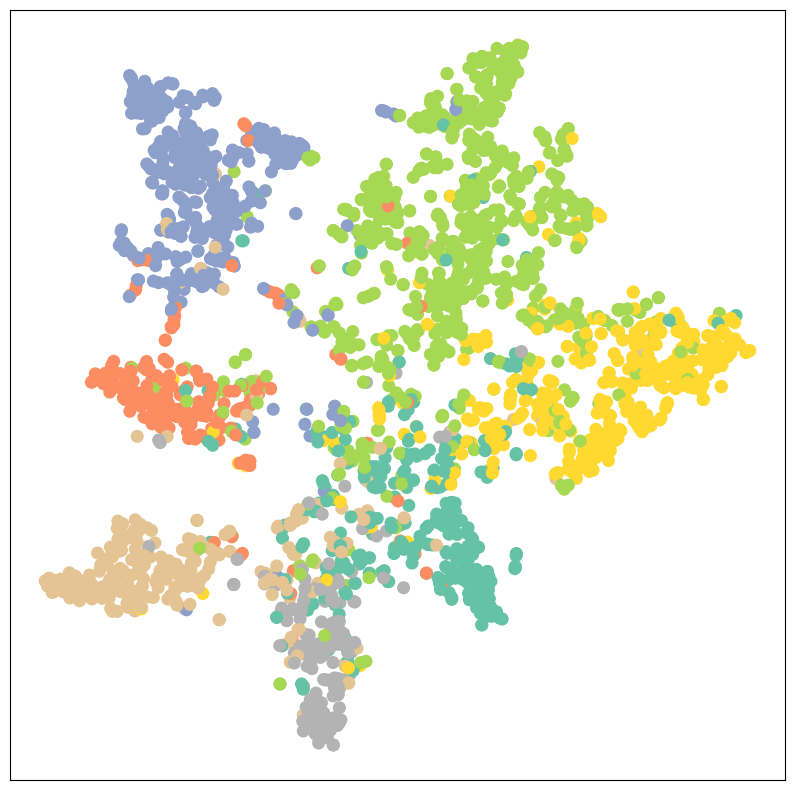

In [13]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [15]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads=8):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 010, Loss: 1.8644
Epoch: 020, Loss: 1.7345
Epoch: 030, Loss: 1.5386
Epoch: 040, Loss: 1.3285
Epoch: 050, Loss: 1.0956
Epoch: 060, Loss: 0.9298
Epoch: 070, Loss: 0.7471
Epoch: 080, Loss: 0.6938
Epoch: 090, Loss: 0.5682
Epoch: 100, Loss: 0.4959
Epoch: 110, Loss: 0.4667
Epoch: 120, Loss: 0.4352
Epoch: 130, Loss: 0.4522
Epoch: 140, Loss: 0.4155
Epoch: 150, Loss: 0.4097
Epoch: 160, Loss: 0.3266
Epoch: 170, Loss: 0.3224
Epoch: 180, Loss: 0.3503
Epoch: 190, Loss: 0.3138
Epoch: 200, Loss: 0.2985
Test Accuracy: 0.8070
